In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
!pip install pvlib

In [26]:
!pip install tensorflow

In [27]:
df = pd.read_csv("cleaned_rad_time_series.csv", parse_dates=['DATETIME']) # to force pandas to read columns with dates(strings) as the datetime objects instead

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22673 entries, 0 to 22672
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATETIME        22673 non-null  datetime64[ns]
 1   DIFFUSE MJ/m^2  22673 non-null  float64       
 2   GLOBAL MJ/m^2   22673 non-null  float64       
 3   YEAR            22673 non-null  int64         
 4   HOUR_SIN        22673 non-null  float64       
 5   HOUR_COS        22673 non-null  float64       
 6   MONTH_SIN       22673 non-null  float64       
 7   MONTH_COS       22673 non-null  float64       
 8   DIRECT MJ/m^2   22673 non-null  float64       
 9   LATITUDE        22673 non-null  float64       
 10  LONGITUDE       22673 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 1.9 MB


FEATURE ENGINEERING

In [29]:
from pvlib import solarposition, irradiance

df['DATETIME'] = df['DATETIME'].dt.tz_localize('Asia/Kolkata')
def calculate_solar_features(row):
    solpos = solarposition.get_solarposition(
        time=row['DATETIME'],  # Timezone-aware
        latitude=row['LATITUDE'],  # Station latitude column
        longitude=row['LONGITUDE'],# Station longitude column
        #method='ephemeris'
    )
    return solpos['apparent_zenith'].iloc[0]
df['ZENITH'] = df.apply(calculate_solar_features, axis=1)
#df = df.groupby('STATION', group_keys=False)[['STATION', 'DATETIME', 'DIFFUSE MJ/m^2', 'GLOBAL MJ/m^2', 'LATITUDE', 'LONGITUDE']].apply(calculate_solar_features)

In [30]:
df.head()

,DATETIME,DIFFUSE MJ/m^2,GLOBAL MJ/m^2,YEAR,HOUR_SIN,HOUR_COS,MONTH_SIN,MONTH_COS,DIRECT MJ/m^2,LATITUDE,LONGITUDE,ZENITH
0,1993-01-15 05:00:00+05:30,0.00,0.00,1993,0.965926,2.588190e-01,0.0,1.0,0.00,23.0225,72.5714,122.293354
1,1993-01-15 06:00:00+05:30,0.00,0.00,1993,1.000000,6.123234e-17,0.0,1.0,0.00,23.0225,72.5714,108.868990
2,1993-01-15 07:00:00+05:30,0.02,0.02,1993,0.965926,-2.588190e-01,0.0,1.0,0.00,23.0225,72.5714,95.745966
3,1993-01-15 08:00:00+05:30,0.22,0.44,1993,0.866025,-5.000000e-01,0.0,1.0,0.22,23.0225,72.5714,82.960584
4,1993-01-15 09:00:00+05:30,0.40,1.18,1993,0.707107,-7.071068e-01,0.0,1.0,0.78,23.0225,72.5714,71.098836


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22673 entries, 0 to 22672
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype                       
---  ------          --------------  -----                       
 0   DATETIME        22673 non-null  datetime64[ns, Asia/Kolkata]
 1   DIFFUSE MJ/m^2  22673 non-null  float64                     
 2   GLOBAL MJ/m^2   22673 non-null  float64                     
 3   YEAR            22673 non-null  int64                       
 4   HOUR_SIN        22673 non-null  float64                     
 5   HOUR_COS        22673 non-null  float64                     
 6   MONTH_SIN       22673 non-null  float64                     
 7   MONTH_COS       22673 non-null  float64                     
 8   DIRECT MJ/m^2   22673 non-null  float64                     
 9   LATITUDE        22673 non-null  float64                     
 10  LONGITUDE       22673 non-null  float64                     
 11  ZENITH          22673 non-nu

In [34]:
#split data into test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = df[['LATITUDE', 'LONGITUDE','HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'ZENITH']]  # Features
y = df[['GLOBAL MJ/m^2', 'DIFFUSE MJ/m^2']]  # Target variable

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

RANDOM FOREST

In [35]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(x_train_scaled, y_train)
rf_pred = rf_model.predict(x_test_scaled)

# Assuming 'y_test' contains actual values and 'predictions' contains model predictions
r2 = r2_score(y_test, rf_pred)
print(f"R-squared: {r2}")

r2_per_output = r2_score(y_test, rf_pred, multioutput='raw_values')
print(f"R² per target: {r2_per_output}")

target_names = ['GLOBAL MJ/m^2', 'DIFFUSE MJ/m^2']
for name, score in zip(target_names, r2_per_output):
    print(f"R² for {name}: {score:.3f}")

R-squared: 0.9237416316725913
R² per target: [0.95270161 0.89478165]
R² for GLOBAL MJ/m^2: 0.953
R² for DIFFUSE MJ/m^2: 0.895


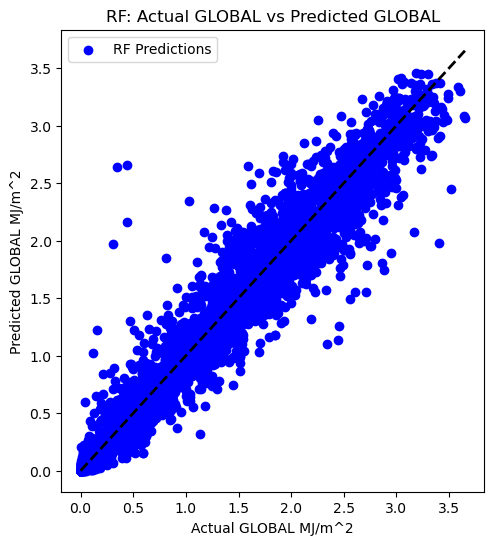

In [40]:
global_actual = y_test['GLOBAL MJ/m^2'].values  # Convert y_test to numpy array if it's a DataFrame
global_pred = rf_pred[:, 0]  # Assuming first column of predictions is Global Radiation

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(global_actual, global_pred, color='blue', label='RF Predictions')
plt.plot([y_test['GLOBAL MJ/m^2'].min(), y_test['GLOBAL MJ/m^2'].max()],
         [y_test['GLOBAL MJ/m^2'].min(), y_test['GLOBAL MJ/m^2'].max()], 'k--', lw=2)
plt.title('RF: Actual GLOBAL vs Predicted GLOBAL')
plt.xlabel('Actual GLOBAL MJ/m^2')
plt.ylabel('Predicted GLOBAL MJ/m^2')
plt.legend()

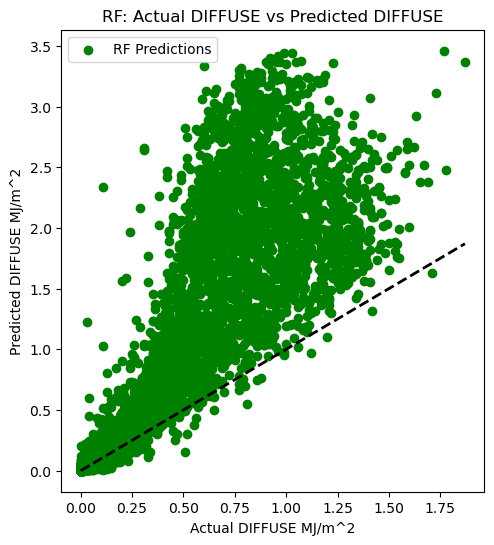

In [41]:
diffuse_actual = y_test['DIFFUSE MJ/m^2'].values  # Convert y_test to numpy array if it's a DataFrame
diffuse_pred = rf_pred[:, 0]  # Assuming first column of predictions is Global Radiation

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(diffuse_actual, diffuse_pred, color='green', label='RF Predictions')
plt.plot([y_test['DIFFUSE MJ/m^2'].min(), y_test['DIFFUSE MJ/m^2'].max()],
         [y_test['DIFFUSE MJ/m^2'].min(), y_test['DIFFUSE MJ/m^2'].max()], 'k--', lw=2)
plt.title('RF: Actual DIFFUSE vs Predicted DIFFUSE')
plt.xlabel('Actual DIFFUSE MJ/m^2')
plt.ylabel('Predicted DIFFUSE MJ/m^2')
plt.legend()

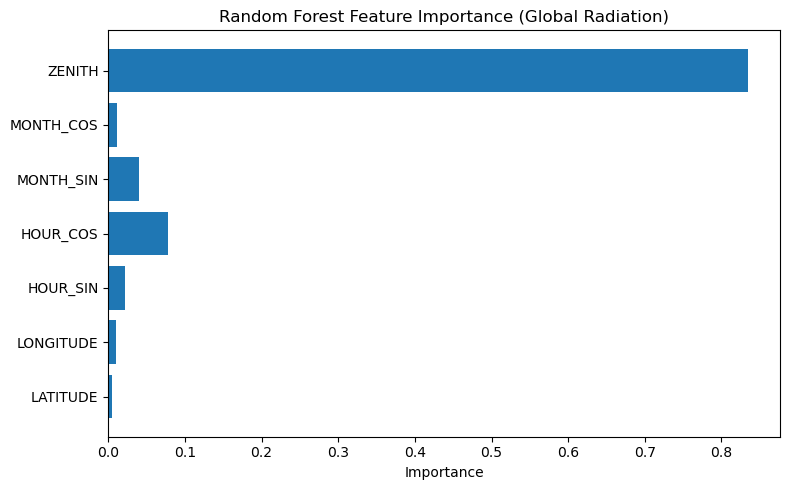

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances from the first regressor (Global radiation)
importances = rf_model.estimators_[0].feature_importances_
feature_names = x.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance (Global Radiation)')
plt.tight_layout()
plt.show()